# Análisis de Redes Sociales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import json
import os
import re
import nltk
from nltk.corpus import stopwords
import string
from unidecode import unidecode
from wordcloud import WordCloud
from collections import Counter

In [2]:
# nltk.download('stopwords')

## 2. Carga de Archivos

In [3]:
def load_tweets(file_path):
    tweets = []
    with open(file_path, 'r', encoding='utf-16') as file:
        for line in file:
            line = line.strip()
            try:
                tweets.append(json.loads(line))
            except:
                pass
    return pd.DataFrame(tweets)

## 3. Limpieza y Preprocesamiento de Datos

In [4]:
def parse_nested_json(x):
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except json.JSONDecodeError:
            return None
    else:
        return x

In [5]:
stop_words = set(stopwords.words('spanish'))

Definimos el preprocesamiento de texto

In [6]:
def preprocess_text(text):
    # Convertir el texto a minúsculas
    text = text.lower()

    # Quitar URLs
    text = re.sub(r'http\S+', '', text)

    # Quitar caracteres especiales como `#`, `@` y apóstrofes
    text = re.sub(r'[@#\'’]', '', text)

    # Quitar números
    text = re.sub(r'\d+', '', text)

    # Quitar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Normalizar caracteres acentuados
    text = unidecode(text)

    # Quitar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

Definimos el flujo de procesamiento de los archivos

In [7]:
def process_file(file_path):
    df = load_tweets(file_path)

    # Convert the data in the columns from JSON strings to dictionaries
    nested_columns = ['user', 'retweetedTweet', 'quotedTweet', 'mentionedUsers', 'inReplyToUser', 'media']
    for column in nested_columns:
        if column in df.columns:
            df[column] = df[column].apply(parse_nested_json)
            
    # Normalize the username
    df['user'] = df['user'].apply(lambda x: x['username'].lower())

    # Convert the date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Preprocess text
    df['processed_text'] = df['rawContent'].apply(preprocess_text)

    # Extract mentioned users and normalize them
    df['mentioned_users'] = df['mentionedUsers'].apply(lambda users: [user['username'].lower() for user in users])

    # Find the usernames that are mentioned in the text
    df['replied_to'] = df['inReplyToUser'].apply(lambda x: x['username'].lower() if pd.notnull(x) else None)
    
    # Check if the tweet is a retweet
    df['quoted'] = df['quotedTweet'].apply(lambda x: x['user']['username'].lower() if pd.notnull(x) else None)

    df = df.copy()  # Avoid SettingWithCopyWarning

    return df

In [8]:
df_trafico = process_file('data/traficogt.txt')

In [9]:
df_trafico.head()

,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,source,sourceUrl,sourceLabel,media,card,_type,processed_text,mentioned_users,replied_to,quoted
0,1834236045598056867,1834236045598056867,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,traficogt,es,Es comprensible la resolución... El ruso sabe ...,0,0,1,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,comprensible resolucion ruso sabe engrasar maq...,[],None,monymmorales
1,1834029142565658846,1834029142565658846,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,monymmorales,es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",{'title': 'La Corte de Constitucionalidad orde...,snscrape.modules.twitter.Tweet,corrupcion ccguatemala descarada falsificacion...,[cc_guatemala],None,None
2,1834039491826180424,1834039491826180424,https://x.com/animaldgalaccia/status/183403949...,2024-09-12 01:21:04+00:00,animaldgalaccia,qme,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,...,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,pncdeguatemala mingobguate fjimenezmingob dieg...,"[pncdeguatemala, mingobguate, fjimenezmingob, ...",pncdeguatemala,None
3,1833963729136091179,1833963729136091179,https://x.com/EstacionDobleA/status/1833963729...,2024-09-11 20:20:01+00:00,estaciondoblea,qam,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,0,0,0,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,amilcarmontejo aztecanoticiagt bancadasemilla ...,"[amilcarmontejo, aztecanoticiagt, bancadasemil...",estaciondoblea,None
4,1833665391698092330,1833665391698092330,https://x.com/CubReserva/status/18336653916980...,2024-09-11 00:34:31+00:00,cubreserva,es,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,0,0,1,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,aztecanoticiagt conapgt denunciaempagua munigu...,"[soy_502, aztecanoticiagt, conapgt, denunciaem...",cubreserva,None


In [10]:
df_arevalo = process_file('data/tioberny.txt')

In [11]:
df_arevalo.head()

,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,source,sourceUrl,sourceLabel,media,card,_type,processed_text,mentioned_users,replied_to,quoted
0,1834281080029110288,1834281080029110288,https://x.com/La_ReVoluZzion/status/1834281080...,2024-09-12 17:21:03+00:00,la_revoluzzion,es,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",0,0,0,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,confirmado companeres impuesto usembassyguate ...,"[usembassyguate, 48cantonestoto, usaidguate, u...",None,xelanewsgt
1,1834252464092069901,1834252464092069901,https://x.com/XelaNewsGt/status/18342524640920...,2024-09-12 15:27:20+00:00,xelanewsgt,es,#URGENTE Lo que los medios #faferos no informa...,12,80,142,...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [{'thumbnailUrl': 'ht...",None,snscrape.modules.twitter.Tweet,urgente medios faferos informaron ayer acerca ...,[],None,None
2,1834280919336976681,1834280919336976681,https://x.com/M24095273/status/183428091933697...,2024-09-12 17:20:25+00:00,m24095273,es,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,0,0,0,...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,ivanduque barevalodeleon usaste pegasus espiar...,"[ivanduque, barevalodeleon]",ivanduque,None
3,1834280512933732694,1834280512933732694,https://x.com/carlosalbesc/status/183428051293...,2024-09-12 17:18:48+00:00,carlosalbesc,es,@IvanDuque @BArevalodeLeon Entre Ellos se enti...,0,0,0,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,ivanduque barevalodeleon entienden bien si est...,"[ivanduque, barevalodeleon]",ivanduque,None
4,1834279986254987428,1834279986254987428,https://x.com/Brenda_AGN/status/18342799862549...,2024-09-12 17:16:42+00:00,brenda_agn,es,El presidente @BArevalodeLeon y la vicepreside...,0,0,0,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,{'photos': [{'url': 'https://pbs.twimg.com/med...,None,snscrape.modules.twitter.Tweet,presidente barevalodeleon vicepresidenta karin...,"[barevalodeleon, karinherreravp, agn_noticias,...",None,None


Extraemos un grafo de interacciones

In [12]:
def extract_interactions(df):
    edges = []
    for _, row in df.iterrows():
        if row['mentioned_users']:
            for mentioned in row['mentioned_users']:
                edges.append((row['user'], mentioned, 'mention'))
        if row['replied_to']:
            edges.append((row['user'], row['replied_to'], 'reply'))
        if row['quoted']:
            edges.append((row['user'], row['quoted'], 'retweet'))

    edges_df = pd.DataFrame(edges, columns=['source', 'target', 'type'])
    G = nx.from_pandas_edgelist(edges_df, source='source', target='target', edge_attr='type', create_using=nx.DiGraph())
    return G

In [13]:
G_trafico = extract_interactions(df_trafico)

In [14]:
G_arevalo = extract_interactions(df_arevalo)

In [15]:
print(f"El grafo de tráfico tiene {G_trafico.number_of_nodes()} nodos y {G_trafico.number_of_edges()} aristas")

El grafo de tráfico tiene 2744 nodos y 7569 aristas


In [16]:
print(f"El grafo de Arevalo tiene {G_arevalo.number_of_nodes()} nodos y {G_arevalo.number_of_edges()} aristas")

El grafo de Arevalo tiene 3134 nodos y 12524 aristas


## 4. Análisis Exploratorio

In [17]:
def analyze_tweet_interactions(df):
    interactions = {
        'total_tweets': len(df),
        'replies': df['replied_to'].notnull().sum(),
        'retweets': df['quoted'].notnull().sum(),
        'mentions': df['mentioned_users'].apply(lambda x: len(x) > 0).sum()
    }
    return interactions

In [18]:
def get_frequent_hashtags(df):
    hashtags = df['hashtags'].explode().dropna()
    return Counter(hashtags).most_common(10)

In [19]:
def get_word_cloud(df, column):
    text = ' '.join(df[column].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color ='white', min_font_size = 10, collocations=False, colormap='viridis').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [20]:
inter_arevalo = analyze_tweet_interactions(df_arevalo)
inter_trafico = analyze_tweet_interactions(df_trafico)

In [21]:
unq_users_arevalo = df_arevalo['user'].nunique()
unq_users_traffic = df_trafico['user'].nunique()

In [22]:
common_hashtags_arevalo = get_frequent_hashtags(df_arevalo)
common_hashtags_trafico = get_frequent_hashtags(df_trafico)

In [23]:
print("Bernardo Arévalo:")
print("\tInteracciones: ", inter_arevalo)
print("\tNúmero de tweets: ", len(df_arevalo))
print("\tUsuarios únicos: ", unq_users_arevalo)
print("\tHashtags más frecuentes: ", common_hashtags_arevalo)
print("\nTraficoGT:")
print("\tInteracciones:", inter_trafico)
print("\tNúmero de tweets: ", len(df_trafico))
print("\tUsuarios únicos: ", unq_users_traffic)
print("\tHashtags más frecuentes: ", common_hashtags_trafico)

Bernardo Arévalo:
	Interacciones:  {'total_tweets': 5019, 'replies': 4370, 'retweets': 295, 'mentions': 4836}
	Número de tweets:  5019
	Usuarios únicos:  2620
	Hashtags más frecuentes:  [('URGENTE', 26), ('GuatemalaSaleAdelante', 25), ('MinfinSaleAdelante', 17), ('Guatemala', 15), ('Presupuesto2025', 14), ('UnPresupuestoParaLaPoblación', 13), ('EnElPaísDCA', 12), ('NacionalesAGN', 8), ('XelaNews', 7), ('ElEstor', 7)]

TraficoGT:
	Interacciones: {'total_tweets': 5604, 'replies': 4150, 'retweets': 611, 'mentions': 4487}
	Número de tweets:  5604
	Usuarios únicos:  2071
	Hashtags más frecuentes:  [('AhoraLH', 18), ('AHORA', 18), ('Guatemala', 16), ('RenuncienGolpistas', 13), ('URGENTE', 10), ('guatemala', 9), ('ParoNacionalIndefinido', 9), ('Ahora', 8), ('LaHoraDeActualizarnos', 8), ('GuateResiste', 8)]


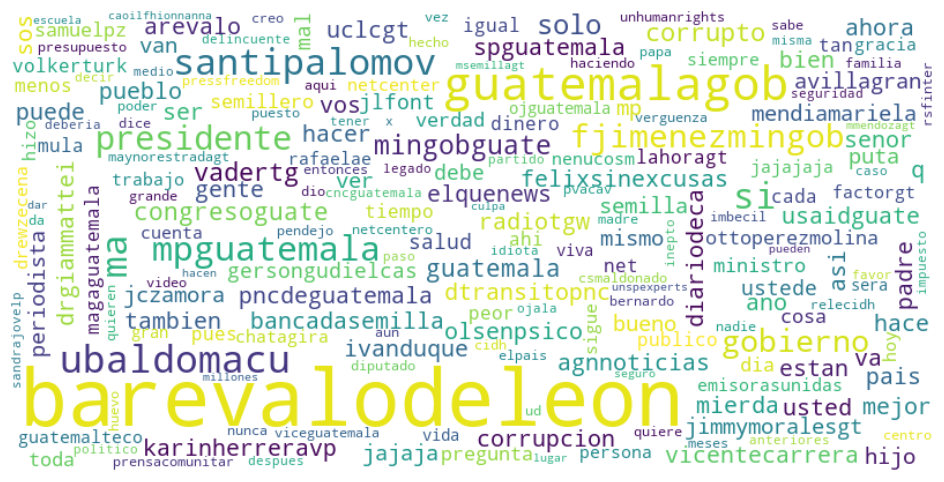

In [24]:
get_word_cloud(df_arevalo, 'processed_text')

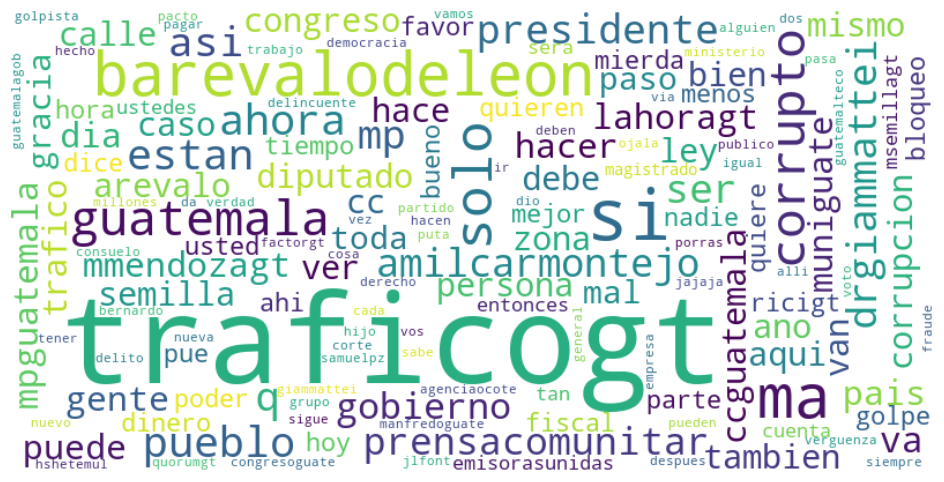

In [25]:
get_word_cloud(df_trafico, 'processed_text')

### 4.2 Preguntas Interesantes

#### Bernardo Arévalo
##### ¿Quiénes son las cuentas que más se mencionan junto a la del presidente?


In [26]:
def get_frequent_mentions(df, username):
    mentions = df[df['mentioned_users'].apply(lambda x: username in x)]['mentioned_users'].explode().dropna()
    return Counter(mentions).most_common(10)

In [27]:
frequent_mentions_arevalo = get_frequent_mentions(df_arevalo, 'barevalodeleon')

In [28]:
print("Cuentas más mencionadas junto a Bernardo Arévalo:")
print(frequent_mentions_arevalo)

Cuentas más mencionadas junto a Bernardo Arévalo:
[('barevalodeleon', 4830), ('guatemalagob', 909), ('ubaldomacu', 574), ('santipalomov', 518), ('mpguatemala', 459), ('fjimenezmingob', 400), ('mingobguate', 285), ('__vadertg', 271), ('congresoguate', 254), ('diariodeca', 219)]


Las cuentas que más se mencionan junto a Bernardo Arévalo son:
- **@guatemalagob**: Es la cuenta del Gobierno de Guatemala
- **@ubaldomacu**: Puede ser un usuario que genera muchas menciones.
- **@santipalomov**: Puede ser un usuario que genera muchas menciones.

##### ¿Cuál es el hashtag más frecuente?

In [29]:
common_hashtags_arevalo = get_frequent_hashtags(df_arevalo)
common_hashtags_arevalo

[('URGENTE', 26),
 ('GuatemalaSaleAdelante', 25),
 ('MinfinSaleAdelante', 17),
 ('Guatemala', 15),
 ('Presupuesto2025', 14),
 ('UnPresupuestoParaLaPoblación', 13),
 ('EnElPaísDCA', 12),
 ('NacionalesAGN', 8),
 ('XelaNews', 7),
 ('ElEstor', 7)]

Los hashtags más frecuentes son:
- **#URGENTE**: Se utiliza para indicar que la información es de suma importancia.
- **#GuatemalaSaleAdelante**: Se utiliza para expresar optimismo sobre el futuro del país.
- **#MinfinSaleAdelante**: Se utiliza para expresar optimismo sobre el futuro del Ministerio de Finanzas.

##### ¿Cuál es la palabra más frecuente que no es una cuenta o hashtag?

In [30]:
all_users = df_arevalo['user'].explode().dropna()
all_users = pd.concat([all_users, df_arevalo['replied_to'].dropna()])
all_users = pd.concat([all_users, df_arevalo['quoted'].dropna()])
all_users = pd.concat([all_users, df_arevalo['mentioned_users'].explode().dropna()])
all_users = all_users.unique()
all_hashtags = df_arevalo['hashtags'].explode().dropna()

In [31]:
def get_frequent_words(df, column):
    words = ' '.join(df[column].tolist()).split()
    for word in words:
        if word in all_users or word in all_hashtags:
            words.remove(word)
    return Counter(words).most_common(15)

In [32]:
frequent_words_arevalo = get_frequent_words(df_arevalo, 'processed_text')
frequent_words_arevalo

[('barevalodeleon', 2156),
 ('mas', 500),
 ('si', 485),
 ('presidente', 431),
 ('mpguatemala', 336),
 ('gobierno', 334),
 ('solo', 307),
 ('vadertg', 274),
 ('mingobguate', 211),
 ('arevalo', 209),
 ('usaidguate', 207),
 ('vos', 197),
 ('asi', 190),
 ('spguatemala', 189),
 ('ser', 185)]

Pareciera ser que las palabras más comunes son *si*, *presidente*, *solo*. Esto pareciera ser una alusión a la cantidad de gente que expresa su opinión sobre el presidente; posiblemente, proponiendo alguna alternativa.

#### TraficoGT
##### ¿Cuáles son los hashtags más frecuentes?

In [33]:
common_hashtags_trafico = get_frequent_hashtags(df_trafico)
common_hashtags_trafico

[('AhoraLH', 18),
 ('AHORA', 18),
 ('Guatemala', 16),
 ('RenuncienGolpistas', 13),
 ('URGENTE', 10),
 ('guatemala', 9),
 ('ParoNacionalIndefinido', 9),
 ('Ahora', 8),
 ('LaHoraDeActualizarnos', 8),
 ('GuateResiste', 8)]

Los hashtags más frecuentes son:
- **#AhoraLH**: Se utiliza para indicar que la información publicada por el diario La Hora
- **#Ahora**: Se utiliza para indicar que la información es actual.
- **#Guatemala**: Se utiliza para indicar que la información es sobre Guatemala.

##### ¿Cuál es la palabra más frecuente que parece representar la causa del tráfico?

In [34]:
frequent_words_trafico = get_frequent_words(df_trafico, 'processed_text')
frequent_words_trafico

[('traficogt', 1092),
 ('si', 614),
 ('mas', 445),
 ('solo', 323),
 ('barevalodeleon', 265),
 ('estan', 210),
 ('corruptos', 201),
 ('ahora', 200),
 ('q', 191),
 ('asi', 191),
 ('ser', 185),
 ('pueblo', 185),
 ('mp', 182),
 ('presidente', 171),
 ('gobierno', 143)]

Las palabras más comunes parecen hacer referencia a que el tráfico es por culpa del gobierno, ya que las palabras más comunes son *gobierno*, *corruptos*, *presidente*.

##### ¿Cuáles son las cuentas que más se mencionan?


In [35]:
frequent_mentions_trafico = get_frequent_mentions(df_trafico, 'traficogt')
frequent_mentions_trafico

[('traficogt', 4243),
 ('barevalodeleon', 399),
 ('amilcarmontejo', 165),
 ('prensacomunitar', 160),
 ('drgiammattei', 140),
 ('mmendoza_gt', 130),
 ('lahoragt', 125),
 ('mpguatemala', 117),
 ('cc_guatemala', 97),
 ('muniguate', 92)]

Las cuentas que más se mencionan junto a TraficoGT son:
- **@traficogt**: Es la cuenta de TraficoGT, por lo que es normal que sea la más mencionada.
- **@barevalodeleon**: Es la cuenta de Bernardo Arévalo, quien también es mencionado en los tweets de TraficoGT.
- **@amilcarmontejo**: Es el director de la Policía Municipal de Tránsito de la Ciudad de Guatemala.

## 5. Análisis de Topología

#### 5.1 Visualización de grafos

In [36]:
def visualize_graph(G, title, top_n=25):
    # Calculate degree centrality to filter the top N nodes
    degree_centrality = nx.degree_centrality(G)

    # Sort nodes by degree centrality and keep only the top N
    top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:top_n]
    subgraph = G.subgraph(top_nodes)  # Create a subgraph with only the top N nodes

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(subgraph, k=0.1)

    # Draw nodes with size and color based on degree centrality
    node_size = [degree_centrality[node] * 1000 for node in subgraph]  # Scale node size
    node_color = [degree_centrality[node] for node in subgraph]  # Color based on centrality
    nodes = nx.draw_networkx_nodes(subgraph, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.viridis, alpha=0.9)

    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, arrowstyle='->', arrowsize=10, edge_color='gray')

    # Draw labels for all the nodes
    degrees = dict(subgraph.degree())
    nx.draw_networkx_labels(subgraph, pos, labels={node: node for node, degree in degrees.items() if degree > 5}, font_size=10)

    # Add a color bar for degree centrality
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(degree_centrality.values()), vmax=max(degree_centrality.values())))
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca(), label='Degree Centrality')

    plt.title(f"{title} - Top {top_n} Nodes by Degree Centrality")
    plt.show()

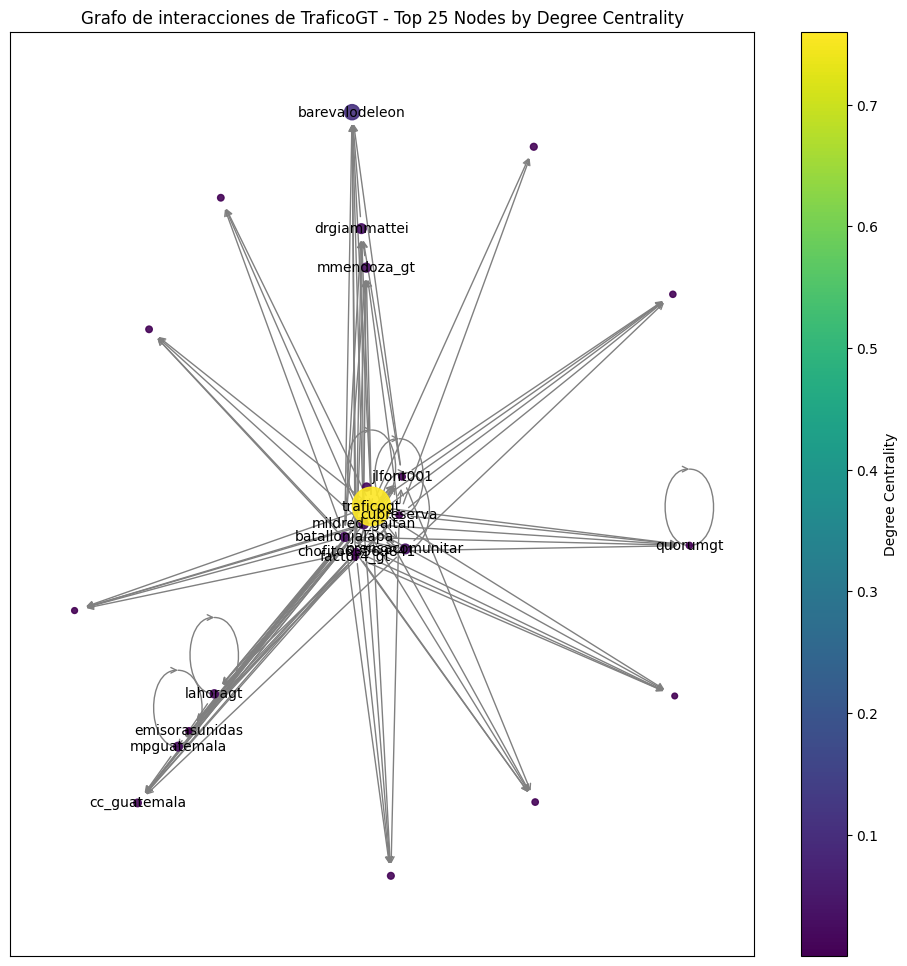

In [37]:
visualize_graph(G_trafico, 'Grafo de interacciones de TraficoGT')

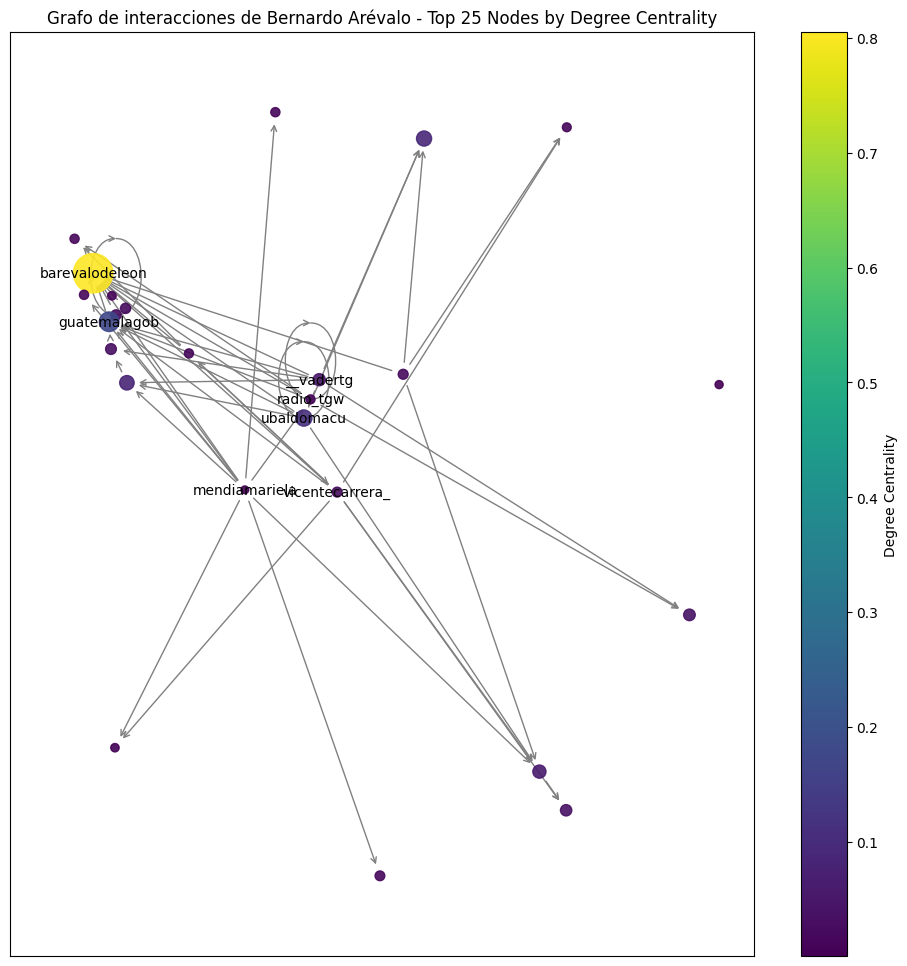

In [38]:
visualize_graph(G_arevalo, 'Grafo de interacciones de Bernardo Arévalo')

#### 5.2 Métricas

In [39]:
def calculate_network_metrics(G):
    # Densidad de la red
    density = nx.density(G)

    # Convert to undirected graph for diameter calculation
    if nx.is_connected(G.to_undirected()):
        diameter = nx.diameter(G.to_undirected())
    else:
        diameter = float('inf')  # Si la red no está conectada, el diámetro es infinito

    # Coeficiente de agrupamiento
    clustering_coefficient = nx.average_clustering(G)

    return {
        'density': density,
        'diameter': diameter,
        'clustering_coefficient': clustering_coefficient
    }

In [40]:
metrics_trafico = calculate_network_metrics(G_trafico)

In [41]:
metrics_arevalo = calculate_network_metrics(G_arevalo)

In [42]:
print("Métricas de la red de TraficoGT:")
print(f"Densidad: {metrics_trafico['density']}")
print(f"Diámetro: {metrics_trafico['diameter']}")
print(f"Coeficiente de agrupamiento: {metrics_trafico['clustering_coefficient']}")

Métricas de la red de TraficoGT:
Densidad: 0.0010056077011295118
Diámetro: 4
Coeficiente de agrupamiento: 0.17672844963233292


In [43]:
print("Métricas de la red de Bernardo Arévalo:")
print(f"Densidad: {metrics_arevalo['density']}")
print(f"Diámetro: {metrics_arevalo['diameter']}")
print(f"Coeficiente de agrupamiento: {metrics_arevalo['clustering_coefficient']}")

Métricas de la red de Bernardo Arévalo:
Densidad: 0.0012755094246539962
Diámetro: 6
Coeficiente de agrupamiento: 0.19174102925467765


## 6. Identificación de comunidades
### 6.1 Algoritmo de Louvain
Este es un algoritmo que permite manejar redes grandes y tiene un enfoque que busca maximizar la modularidad de la red; permitiendo mejorar la calidad de las comunidades identificadas. Consta de dos fases:
1. **Asignación de comunidades**: Se asigna cada nodo a una comunidad distinta. Luego, se recorren los nodos y se asignan a la comunidad que maximiza la modularidad.
2. **Agrupación de comunidades**: Se crea un nuevo grafo donde los nodos son las comunidades identificadas en la fase anterior. Se conectan las comunidades que comparten más aristas y se repiten las fases 1 y 2 hasta que no se pueda mejorar la modularidad.

Referencia: [Detección de comunidades en grafos y redes con python](https://cienciadedatos.net/documentos/pygml02-detecion-comunidades-grafos-redes-python)

In [44]:
def detect_communities(G, top_n=3):
    communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
    communities = sorted(communities, key=len, reverse=True)[:top_n]
    return communities

In [45]:
def characterize_communities(G, df, communities):
    community_characteristics = []

    for i, community in enumerate(communities):
        subgraph = G.subgraph(community)
        community_df = df[df['user'].isin(community)]

        # Tamaño de la comunidad
        size = len(community)

        # Interacciones dentro de la comunidad
        interactions = subgraph.number_of_edges()

        # Temas principales de conversación
        words = ' '.join(community_df['processed_text'].tolist()).split()
        word_counts = Counter(words).most_common(10)

        community_characteristics.append({
            'community': i + 1,
            'size': size,
            'interactions': interactions,
            'top_words': word_counts
        })

    return community_characteristics

In [46]:
def plot_communities(G, communities):
    fig, axes = plt.subplots(1, len(communities), figsize=(15, 5))
    
    for i, community in enumerate(communities):
        subgraph = G.subgraph(community)
        pos = nx.spring_layout(subgraph, k=0.1)
        nx.draw(subgraph, pos, with_labels=False, ax=axes[i])
        axes[i].set_title(f"Comunidad {i + 1}")
        
        print(f"Comunidad {i + 1}: {len(community)} nodos")
        print(community)
        
    plt.show()

In [47]:
communities_trafico = detect_communities(G_trafico)
characteristics_trafico = characterize_communities(G_trafico, df_trafico, communities_trafico)

In [48]:
communities_arevalo = detect_communities(G_arevalo)
characteristics_arevalo = characterize_communities(G_arevalo, df_arevalo, communities_arevalo)

Comunidad 1: 955 nodos
frozenset({'manupelman', 'pirir9pirir', 'ottoareyesestr2', 'jemanuelth', 'jgcasasola', 'mercedesba33833', 'voznisho', 'arrabeibarra', 'dinoeca30', 'rojitosantacruz', 'eddyarredondo23', 'diego21709067', 'manueldiva56278', 'santipalomov', 'albinoburatti', 'jennygt100', 'foppaguate', 'gecali3', 'lopez_alma', 'eliseobac', 'menendezamc1', 'lrlopez2020', 'orlandopamal', 'maya25cardenas', 'grupoimg2', 'ronald_sterkel', 'elmora_siu', 'chicote09768995', 'fundesa', 'solaresarriola', 'el_pollo_7', 'stereo100xela', 'lbarreragt', 'xajo1970', 'thevigilantegt', 'dragongt2022', 'juancho8924082', 'manoloalexsand1', 'eddy_ecocharly', 'bofer34', 'vjavierhndz', 'munivcanales', 'marcosantil', 'politiqueros502', '_____das____', 'oecalderonm', 'markcoma80', 'dayankim0501', 'hidden_badass', 'meridagary', 'rec749', 'chappin777', 'dora_melgar', 'guacamolconsal', 'coma_jose', 'camtroussard', 'carlosallarenao', 'anika_cohler', 'osmosis_gt', 'alexcifuen1990', 'e_18_m_12_4', 'elakademicista',

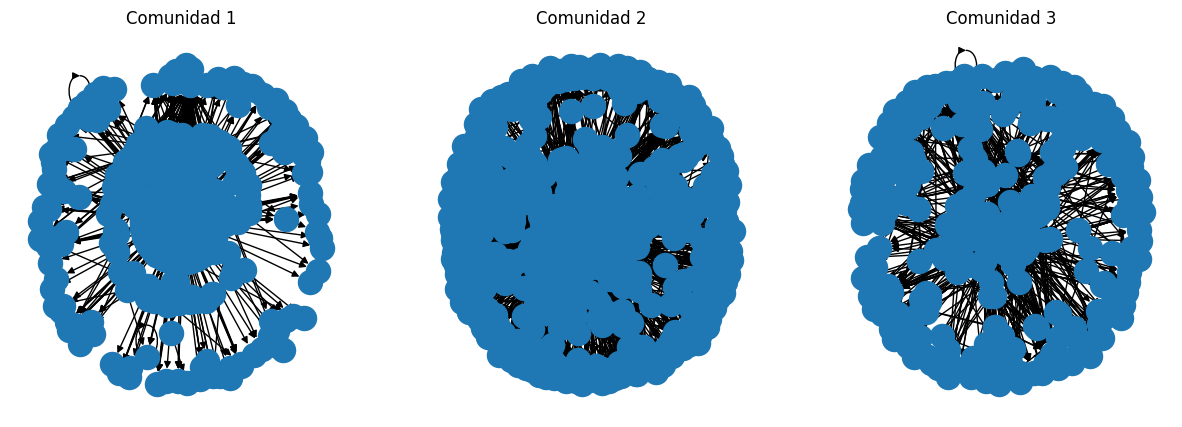

In [49]:
plot_communities(G_trafico, communities_trafico)

In [50]:
for community in characteristics_trafico:
    print(f"Comunidad {community['community']}:")
    print(f"Tamaño: {community['size']}")
    print(f"Interacciones: {community['interactions']}")
    print(f"Temas principales: {community['top_words']}")
    print()

Comunidad 1:
Tamaño: 955
Interacciones: 1455
Temas principales: [('traficogt', 1189), ('si', 272), ('barevalodeleon', 263), ('mas', 172), ('solo', 144), ('q', 78), ('guatemala', 76), ('ser', 71), ('corruptos', 70), ('mp', 68)]

Comunidad 2:
Tamaño: 607
Interacciones: 1635
Temas principales: [('traficogt', 1317), ('si', 116), ('mas', 103), ('drgiammattei', 99), ('barevalodeleon', 98), ('mpguatemala', 91), ('ccguatemala', 83), ('mmendozagt', 82), ('corruptos', 77), ('solo', 77)]

Comunidad 3:
Tamaño: 345
Interacciones: 794
Temas principales: [('traficogt', 458), ('amilcarmontejo', 154), ('muniguate', 85), ('trafico', 66), ('zona', 61), ('emisorasunidas', 52), ('calle', 48), ('pmtmuniguate', 38), ('guatemala', 38), ('mas', 38)]



Comunidad 1: 865 nodos
frozenset({'leonard06593335', 'haggonzalez', 'mazariegos_lima', 'ditoalexander20', 'jsotsot', 'car_pal', 'elcabra3232', 'karma_edwin', 'querquitus', 'jcfaroto13', 'elfkingleon69', 'tayoaycinena', 'analucamolinar1', 'airhelp', 'colochodelacruz', 'amilkar31994010', 'carolyfofo', 'royalvaradogt', 'luciourquidez', 'pabloiglesias', 'jtinianoomilton', 'sebvega', 'agentelara2023', 'drferdiaz', 'curulguatemala', 'evils2rd2', 'anibal007', 'bbccss6566', 'vanidades2023', 'katyolarte', 'david_qva', 'm99778r', 'nandiherrera', 'armandoinfo', 'monicarabanale1', 'inafinogenova', 'mauricio_matay', 'elgrossogt', 'chesaregram', 'rafamosquera', 'lacimahorg', 'jrc19782001', 'cantimanuel1', 'asodeguaong', 'silviamhds', 'edwardadam63', 'mario29939056', 'jorgemo60111774', 'cristiianguate', 'wola_org', 'irenemontero', 'ashparfavor', 'luis_sinfiltro', 'rosariosoto2020', 'rmensoruin', 'wohlivanderss', 'vegafredy882', 'govpt', 'sharongt8', 'electrafacao', 'manushgt', 'negritovb74', 'mecg456

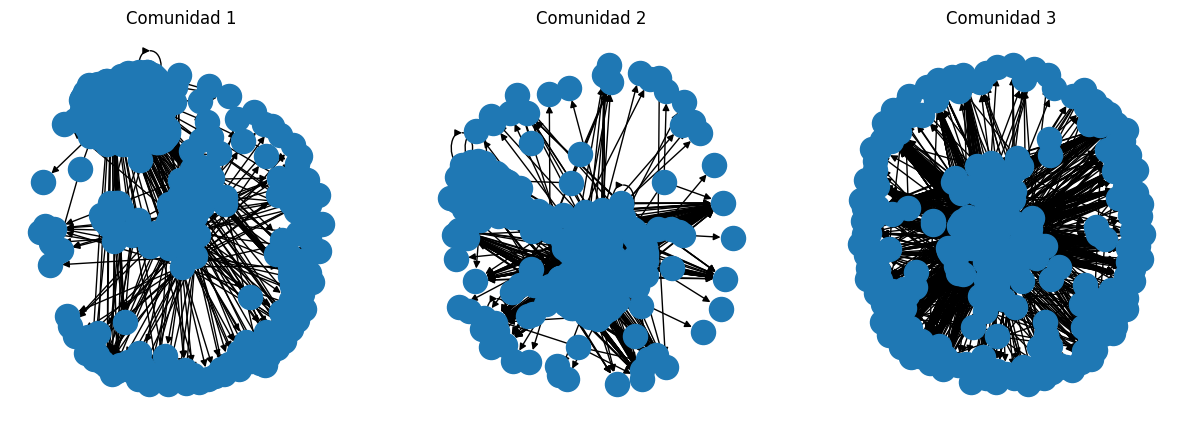

In [51]:
plot_communities(G_arevalo, communities_arevalo)

In [52]:
for community in characteristics_arevalo:
    print(f"Comunidad {community['community']}:")
    print(f"Tamaño: {community['size']}")
    print(f"Interacciones: {community['interactions']}")
    print(f"Temas principales: {community['top_words']}")
    print()

Comunidad 1:
Tamaño: 865
Interacciones: 1325
Temas principales: [('barevalodeleon', 953), ('presidente', 131), ('ivanduque', 129), ('si', 100), ('arevalo', 79), ('mas', 78), ('padre', 69), ('usted', 64), ('gersongudielcas', 59), ('gobierno', 58)]

Comunidad 2:
Tamaño: 594
Interacciones: 1830
Temas principales: [('barevalodeleon', 1202), ('ubaldomacu', 453), ('santipalomov', 408), ('mpguatemala', 356), ('guatemalagob', 196), ('vicentecarrera', 141), ('olsenpsico', 136), ('mas', 132), ('uclcgt', 132), ('drgiammattei', 125)]

Comunidad 3:
Tamaño: 477
Interacciones: 1972
Temas principales: [('barevalodeleon', 802), ('vadertg', 218), ('congresoguate', 212), ('usaidguate', 187), ('jczamora', 93), ('bancadasemilla', 88), ('mas', 81), ('guatemalagob', 73), ('si', 70), ('jlfont', 66)]



## 7. Análisis de influencers y nodos clave
### 7.1. Identificación de usuarios influyentes: 
Utiliza métricas de centralidad para identificar los usuarios más influyentes en la red seleccionada.

### Trafico GT

In [53]:
# Calculate the centrality metrics
degree_centrality = nx.degree_centrality(G_trafico)
closeness_centrality = nx.closeness_centrality(G_trafico)
betweenness_centrality = nx.betweenness_centrality(G_trafico)

In [54]:
# Add the centrality metrics to the DataFrame
df_trafico['degree_centrality'] = df_trafico['user'].map(degree_centrality)
df_trafico['closeness_centrality'] = df_trafico['user'].map(closeness_centrality)
df_trafico['betweenness_centrality'] = df_trafico['user'].map(betweenness_centrality)

In [58]:
# Display the centrality metrics for the top 10 users, only showing one time each user
df_trafico[['user', 'degree_centrality', 'closeness_centrality', 'betweenness_centrality']].drop_duplicates().sort_values('degree_centrality', ascending=False).head(10)

,user,degree_centrality,closeness_centrality,betweenness_centrality
0,traficogt,0.759752,0.689391,0.075981
13,prensacomunitar,0.048487,0.356465,0.000497
1678,drgiammattei,0.048487,0.359164,0.000006
326,mildred_gaitan,0.045935,0.345976,0.011207
1263,mmendoza_gt,0.041925,0.355386,0.000527
90,batallonjalapa,0.040467,0.000729,0.000026
990,mpguatemala,0.038644,0.358535,0.000006
47,lahoragt,0.034634,0.353740,0.000073
2208,amilcarmontejo,0.033540,0.033205,0.000013
745,cc_guatemala,0.029530,0.357231,0.000000


### Bernardo Arévalo

In [59]:
# Calculate the centrality metrics
degree_centrality = nx.degree_centrality(G_arevalo)
closeness_centrality = nx.closeness_centrality(G_arevalo)
betweenness_centrality = nx.betweenness_centrality(G_arevalo)

In [60]:
# Add the centrality metrics to the DataFrame
df_arevalo['degree_centrality'] = df_arevalo['user'].map(degree_centrality)
df_arevalo['closeness_centrality'] = df_arevalo['user'].map(closeness_centrality)
df_arevalo['betweenness_centrality'] = df_arevalo['user'].map(betweenness_centrality)

In [61]:
# Display the centrality metrics for the top 10 users, only showing one time each user
df_arevalo[['user', 'degree_centrality', 'closeness_centrality', 'betweenness_centrality']].drop_duplicates().sort_values('degree_centrality', ascending=False).head(10)

,user,degree_centrality,closeness_centrality,betweenness_centrality
660,barevalodeleon,0.805298,0.803718,0.000000
11,guatemalagob,0.198213,0.267468,0.000421
469,ubaldomacu,0.135972,0.156952,0.014752
193,mpguatemala,0.107884,0.160577,0.000071
3922,fjimenezmingob,0.089690,0.195126,0.000175
1757,__vadertg,0.076285,0.104657,0.005116
1725,usaidguate,0.060006,0.124621,0.000050
16,diariodeca,0.054261,0.108829,0.000578
1657,olsenpsico,0.053942,0.089870,0.000000
26,elquenews,0.051069,0.101444,0.000077


## 8. Detección y análisis de grupos aislados
### 8.1. Análisis de subredes y nodos aislados: 
Identifica grupos o subredes aisladas dentro de cada red, que interactúan muy poco con el resto. Realiza un análisis de estos grupos para entender su dinámica y si representan nichos específicos dentro de la red.

### Trafico GT

In [88]:
# Itentify the Weakly Connected Components
wcc_trafico = list(nx.weakly_connected_components(G_trafico))
print(f"Componente débilmente conectada de TraficoGT: {len(wcc_trafico)}")

Componente débilmente conectada de TraficoGT: 1


In [87]:
for i, subnet in enumerate(wcc_trafico):
    #create a subgraph
    subgraph = G_trafico.subgraph(subnet)
    
    # Calculate the centrality metrics
    degree_centrality = nx.degree_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    
    # Add the centrality metrics to the DataFrame
    centrality_df = pd.DataFrame({
        'User': degree_centrality.keys(),
        'Degree Centrality': degree_centrality.values(),
        'Betweenness Centrality': betweenness_centrality.values(),
        'Closeness Centrality': closeness_centrality.values(),
    })
    
    print(f"Subred {i + 1}: Usuarios más influyentes")
    print(centrality_df.sort_values('Degree Centrality', ascending=False).head(5))
    print("-----------")

    #less influential users
    print(f"Subred {i + 1}: Usuarios menos influyentes")
    print(centrality_df.sort_values('Degree Centrality').head(5))
    print("-----------")

Subred 1: Usuarios más influyentes
                User  Degree Centrality  Betweenness Centrality  \
0          traficogt           0.759752                0.075981   
12    barevalodeleon           0.119213                0.000000   
467     drgiammattei           0.048487                0.000006   
18   prensacomunitar           0.048487                0.000497   
331   mildred_gaitan           0.045935                0.011207   

     Closeness Centrality  
0                0.689391  
12               0.381438  
467              0.359164  
18               0.356465  
331              0.345976  
-----------
Subred 1: Usuarios menos influyentes
               User  Degree Centrality  Betweenness Centrality  \
2743    elmeronene1           0.000365                     0.0   
676   stereo100xela           0.000365                     0.0   
1360      rocioxrd_           0.000365                     0.0   
679     p_unionista           0.000365                     0.0   
680      rebkrr

### Bernardo Arévalo

In [89]:
# Identify the largest weakly connected component
wcc_arevalo = list(nx.weakly_connected_components(G_arevalo))
print(f"Componente débilmente conectada de Bernardo Arévalo: {len(wcc_arevalo)}")

Componente débilmente conectada de Bernardo Arévalo: 1


In [86]:
for i, subnet in enumerate(wcc_arevalo):
    #create a subgraph
    subgraph = G_trafico.subgraph(subnet)
    
    # Calculate the centrality metrics
    degree_centrality = nx.degree_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    
    # Add the centrality metrics to the DataFrame
    centrality_df = pd.DataFrame({
        'User': degree_centrality.keys(),
        'Degree Centrality': degree_centrality.values(),
        'Betweenness Centrality': betweenness_centrality.values(),
        'Closeness Centrality': closeness_centrality.values(),
    })
    
    print(f"Subred {i + 1}: Usuarios más influyentes")
    print(centrality_df.sort_values('Degree Centrality', ascending=False).head(5))
    print("-----------")

    # less influential users
    print(f"Subred {i + 1}: Usuarios menos influyentes")
    print(centrality_df.sort_values('Degree Centrality', ascending=True).head(5))
    print("-----------")

Subred 1: Usuarios más influyentes
                User  Degree Centrality  Betweenness Centrality  \
91         traficogt           0.702663                0.113961   
288   barevalodeleon           0.193787                0.000000   
308   mildred_gaitan           0.116864                0.015661   
240   batallonjalapa           0.087278                0.000000   
193  chofito63569841           0.066568                0.000000   

     Closeness Centrality  
91               0.538462  
288              0.340309  
308              0.271093  
240              0.000000  
193              0.000000  
-----------
Subred 1: Usuarios menos influyentes
                User  Degree Centrality  Betweenness Centrality  \
0    mazariegos_lima                0.0                     0.0   
575         don_kamu                0.0                     0.0   
576        gtliberal                0.0                     0.0   
258     blogcatarsis                0.0                     0.0   
584  cesar

Dados estos componentes débilmente conectados, se puede observar que la mayoría de ellos son cuentas sin ningún otro tipo de interacción, por lo que se puede suponer que están hechas para generar comentarios positivos o negativos dentro de una red especifica.

Algunos otros, como la cuenta de noti7guatemala, se puede atribuir su poca conexión a que este tipo de cuentas únicamente postea noticias y no son de uso personal, por lo que no suelen interactuar directamente con las redes objetivo.

Se puede observar que, en el caso de Bernardo Arévalo, existen mas cuentas en la red que no tienen ningún otro tipo de interacción. Debido al carácter político de Arévalo, estas cuentas pueden ser utilizadas principalmente para generar apoyo o desaprobación de forma masiva.

## 9. Análisis de contenido y sentimiento
### 9.1. Análisis de sentimiento: 
Realiza un análisis de sentimiento de los tweets en cada red utilizando técnicas de procesamiento de lenguaje natural (NLP). Identifica si los usuarios están discutiendo temas de manera positiva, negativa o neutral.

In [95]:
from transformers import pipeline
sentiment_pipeline = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

c:\Users\monto\OneDrive\Documents\UVG\8. Octavo semestre\DataSci\Social-Network-Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\monto\OneDrive\Documents\UVG\8. Octavo semestre\DataSci\Social-Network-Analysis\.venv\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\monto\.cache\huggingface\hub\models--nlptown--bert-base-multilingual-uncased-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limita

Se utilizó transformers debido a que esta libreria es inerente al idioma, ya que los tweets están hechos en español. Esta librería utiliza _stars_ para indicar que tan positivo o negativo es un texto, donde _1 star_ es muy negativo y _5 stars_ es muy positivo.

### Trafico GT

In [96]:
df_trafico['sentiment'] = df_trafico['processed_text'].apply(lambda text: sentiment_pipeline(text)[0])

#Divide the sentiment dictionary into two columns
df_trafico['sentiment_label'] = df_trafico['sentiment'].apply(lambda x: x['label'])
df_trafico['sentiment_score'] = df_trafico['sentiment'].apply(lambda x: x['score'])

#sentiment summary
sentiment_summary = df_trafico.groupby('user')['sentiment_label'].value_counts(normalize=True).unstack()
print(sentiment_summary)

sentiment_label  1 star  2 stars  3 stars  4 stars  5 stars
user                                                       
01lu88              1.0      NaN      NaN      NaN      NaN
0s_dev              1.0      NaN      NaN      NaN      NaN
1056_antonio        NaN      NaN      NaN      NaN      1.0
1601jr              NaN      NaN      1.0      NaN      NaN
17147128204ca       NaN      NaN      NaN      1.0      NaN
...                 ...      ...      ...      ...      ...
zarahlu             1.0      NaN      NaN      NaN      NaN
zerimaral3lh1       1.0      NaN      NaN      NaN      NaN
zullyayala23922     1.0      NaN      NaN      NaN      NaN
zullyroca_gi        1.0      NaN      NaN      NaN      NaN
zurdoslowing        1.0      NaN      NaN      NaN      NaN

[2071 rows x 5 columns]


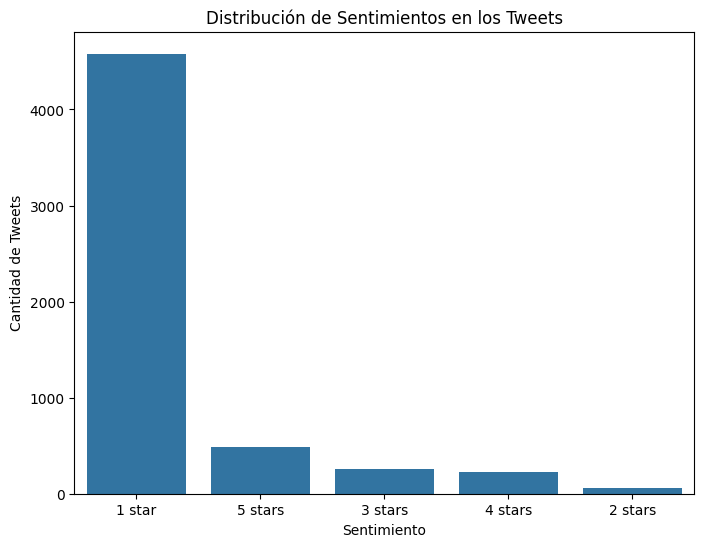

In [97]:
sentiment_counts = df_trafico['sentiment_label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Distribución de Sentimientos en los Tweets")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de Tweets")
plt.show()

### Bernardo Arévalo

In [98]:
df_arevalo['sentiment'] = df_arevalo['processed_text'].apply(lambda text: sentiment_pipeline(text)[0])

#Divide the sentiment dictionary into two columns
df_arevalo['sentiment_label'] = df_arevalo['sentiment'].apply(lambda x: x['label'])
df_arevalo['sentiment_score'] = df_arevalo['sentiment'].apply(lambda x: x['score'])

#sentiment summary
sentiment_summary_arevalo = df_arevalo.groupby('user')['sentiment_label'].value_counts(normalize=True).unstack()
print(sentiment_summary_arevalo)

sentiment_label  1 star  2 stars  3 stars  4 stars  5 stars
user                                                       
0205mh_             NaN      NaN      NaN      NaN      1.0
0515om              NaN      NaN      NaN      NaN      1.0
1056_antonio        0.5      NaN      NaN      NaN      0.5
10elcrack10         1.0      NaN      NaN      NaN      NaN
1207_pedro          1.0      NaN      NaN      NaN      NaN
...                 ...      ...      ...      ...      ...
zeuslvarez4zeus     1.0      NaN      NaN      NaN      NaN
zh1end77            1.0      NaN      NaN      NaN      NaN
zoom_502gt          1.0      NaN      NaN      NaN      NaN
zullyireneayala     NaN      NaN      1.0      NaN      NaN
zunigaariandar      1.0      NaN      NaN      NaN      NaN

[2620 rows x 5 columns]


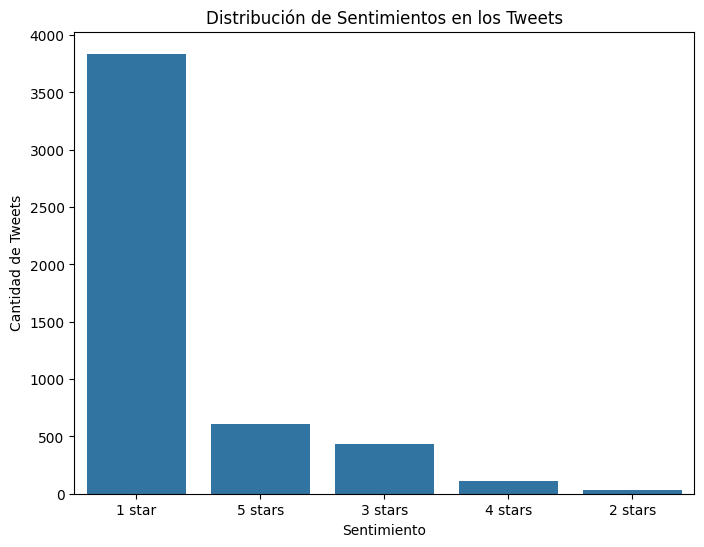

In [99]:
sentiment_counts_arevalo = df_arevalo['sentiment_label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts_arevalo.index, y=sentiment_counts_arevalo.values)
plt.title("Distribución de Sentimientos en los Tweets")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de Tweets")
plt.show()

### 9.2. Identificación de temas: 
Utiliza un análisis de tópicos para identificar los temas principales en cada red. ¿Qué temas son más recurrentes en @traficogt o @bernardoarevalodeleon? ¿Cómo se relacionan estos temas con las comunidades detectadas?

In [100]:
nltk.download('stopwords')

stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=list(stopwords.words('spanish')))

In [105]:
from sklearn.decomposition import LatentDirichletAllocation

In [107]:
def clean_text(text):
    # convert text to lowercase
    text = text.lower()
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

### Trafico GT

In [108]:
df_trafico['cleaned_text'] = df_trafico['processed_text'].apply(clean_text)

In [111]:
X = vectorizer.fit_transform(df_trafico['cleaned_text'])

word_freq = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
word_freq_df = pd.DataFrame({'word': words, 'frequency': word_freq})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

# Remove meaningless words, that are not useful for the analysis
meningless_words = ['gt', 'si', 'traficogt', 'guatemala', 'solo', 'estan', 'asi']
word_freq_df = word_freq_df[~word_freq_df['word'].isin(meningless_words)]

print(word_freq_df.head(10))

                word  frequency
3419             mas        445
559   barevalodeleon        432
1247       corruptos        202
150            ahora        200
4576          pueblo        186
5124             ser        185
3632              mp        182
1758    drgiammattei        175
4420      presidente        171
257   amilcarmontejo        167


In [112]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)

lda_model.fit(X)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Tópico {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)

Tópico 1:
traficogt barevalodeleon si prensacomunitar mas cc ccguatemala presidente asi ser
Tópico 2:
traficogt si mas va solo pueblo van estan hacer ser
Tópico 3:
traficogt si mas solo ahora pues guatemala fiscal gracias pueblo
Tópico 4:
traficogt amilcarmontejo solo lahoragt trafico guatemala corruptos muniguate zona barevalodeleon
Tópico 5:
traficogt mas mp pais consuelo giammattei porras puede caso solo


### Bernardo Arévalo

In [113]:
df_arevalo['cleaned_text'] =df_arevalo['processed_text'].apply(clean_text)

In [118]:
X = vectorizer.fit_transform(df_arevalo['cleaned_text'])

word_freq = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
word_freq_df = pd.DataFrame({'word': words, 'frequency': word_freq})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

# Remove meaningless words, that are not useful for the analysis
meningless_words = ['gt', 'si', 'traficogt', 'guatemala', 'solo', 'estan', 'asi', 'barevalodeleon', 'guatemalagob']
word_freq_df = word_freq_df[~word_freq_df['word'].isin(meningless_words)]

print(word_freq_df.head(10))

                word  frequency
5213      ubaldomacu        573
4716    santipalomov        528
3217             mas        500
3427     mpguatemala        466
4137      presidente        431
2094  fjimenezmingob        403
2256        gobierno        335
3355     mingobguate        290
5280         vadertg        274
1035   congresoguate        253


In [116]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)

lda_model.fit(X)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Tópico {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)

Tópico 1:
barevalodeleon ubaldomacu santipalomov mpguatemala si guatemalagob mas vos bancadasemilla olsenpsico
Tópico 2:
barevalodeleon fjimenezmingob guatemalagob mingobguate diariodeca pncdeguatemala spguatemala agnnoticias radiotgw dtransitopnc
Tópico 3:
barevalodeleon vadertg congresoguate usaidguate emisorasunidas hijo guatemalagob puta comunidad sos
Tópico 4:
barevalodeleon presidente guatemalagob mas felixsinexcusas senor solo arevalo factorgt ser
Tópico 5:
barevalodeleon presidente ivanduque drgiammattei vicentecarrera uclcgt jimmymoralesgt ottoperezmolina karinherreravp mas


En el análisis de sentimiento podemos observar que la mayor parte de tweets, tanto de Bernardo Arévalo o Trafico GT, son negativos, por lo que el enfoque de el análisis de tópicos será realizado en base a este sentimiento.

Para los tweets de Trafico GT, podemos observar se los tópicos reflejan quejas a cerca del trafico, ya sea por algún incidente en especial o el trafico diario. También quejas a cerca de corrupción, en donde se etiqueta a las autoridades como medio de protesta. O algunos más neutrales, como informes sobre la situación del tráfico en el país, en donde suelen mencionar a autoridades o comunicadores, como Amílcar Montejo.
Esto se puede relacionar con las comunidades encontradas debido a que, en estas, podemos observar como se dividen en personas que se quejan sobre el trafico, la corrupción o simplemente están informado algún hecho de transito a las autoridades.


Para los tweets de Bernardo Arévalo, se puede observar que los principales tópicos discutidos incluyen a muchas otras cuentas que corresponden a cargos públicos. Dentro de estos se pueden encontrar principalmente insultos, posiblemente para algún Funcionario público o dirigido a cuentas de opiniones políticas opuestas al gobierno actual, como la cuenta vadergt. También se pueden encontrar temas de discusión actuales, como la situación con el congreso y el ministerio público y el descontento de las personas respecto a estas entidades.
En el caso de las comunidades encontradas para Bernardo Arévalo, podemos observar que se dividen en personas que critican de forma positiva o negativa su trabajo (como la cuenta de vadergt) y el descontento hacia el ministerio público o el congreso de la república.